In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [ ]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T # for simplifying the transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models

In [ ]:
## Now, we import timm, torchvision image models
!pip install timm
import timm
from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm
import time
import copy

In [ ]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [ ]:
def get_data_loaders(data_dir, batch_size, train = False):
    if train:
        #train
        transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
            T.RandomErasing(p=0.2, value='random')
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, "train/"), transform = transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, len(train_data)
    else:
        # val/test
        transform = T.Compose([ # We dont need augmentation for test transforms
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
        ])
        val_data = datasets.ImageFolder(os.path.join(data_dir, "valid/"), transform=transform)
        test_data = datasets.ImageFolder(os.path.join(data_dir, "test/"), transform=transform)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return val_loader, test_loader, len(val_data), len(test_data)

In [ ]:
dataset_path = "/content/drive/MyDrive/Vision_Transformer/butterly_dataset"

In [ ]:
(train_loader, train_data_len) = get_data_loaders(dataset_path, 128, train=True)
(val_loader, test_loader, valid_data_len, test_data_len) = get_data_loaders(dataset_path, 32, train=False)

In [ ]:
classes = get_classes("/content/drive/MyDrive/Vision_Transformer/butterly_dataset/train")
print(classes, len(classes))

['ADONIS', 'AFRICAN GIANT SWALLOWTAIL', 'AMERICAN SNOOT', 'AN 88', 'APPOLLO', 'ARCIGERA FLOWER MOTH', 'ATALA', 'ATLAS MOTH', 'BANDED ORANGE HELICONIAN', 'BANDED PEACOCK', 'BANDED TIGER MOTH', 'BECKERS WHITE', 'BIRD CHERRY ERMINE MOTH', 'BLACK HAIRSTREAK', 'BLUE MORPHO', 'BLUE SPOTTED CROW', 'BROOKES BIRDWING', 'BROWN ARGUS', 'BROWN SIPROETA', 'CABBAGE WHITE', 'CAIRNS BIRDWING', 'CHALK HILL BLUE', 'CHECQUERED SKIPPER', 'CHESTNUT', 'CINNABAR MOTH', 'CLEARWING MOTH', 'CLEOPATRA', 'CLODIUS PARNASSIAN', 'CLOUDED SULPHUR', 'COMET MOTH', 'COMMON BANDED AWL', 'COMMON WOOD-NYMPH', 'COPPER TAIL', 'CRECENT', 'CRIMSON PATCH', 'DANAID EGGFLY', 'EASTERN COMA', 'EASTERN DAPPLE WHITE', 'EASTERN PINE ELFIN', 'ELBOWED PIERROT', 'EMPEROR GUM MOTH', 'GARDEN TIGER MOTH', 'GIANT LEOPARD MOTH', 'GLITTERING SAPPHIRE', 'GOLD BANDED', 'GREAT EGGFLY', 'GREAT JAY', 'GREEN CELLED CATTLEHEART', 'GREEN HAIRSTREAK', 'GREY HAIRSTREAK', 'HERCULES MOTH', 'HUMMING BIRD HAWK MOTH', 'INDRA SWALLOW', 'IO MOTH', 'Iphiclus si

In [ ]:
dataloaders = {
    "train": train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train": train_data_len,
    "val": valid_data_len
}

In [ ]:
print(len(train_loader), len(val_loader), len(test_loader))

99 16 16


In [ ]:
print(train_data_len, valid_data_len, test_data_len)

12594 500 500


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


In [ ]:
for param in model.parameters(): #freeze model
    param.requires_grad = False

n_inputs = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(classes))
)
model = model.to(device)
print(model.head)

Sequential(
  (0): Linear(in_features=192, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=100, bias=True)
)


In [ ]:
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.Adam(model.head.parameters(), lr=0.001)

In [ ]:
# lr scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Initialize the lists to store the losses
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-"*10)

        for phase in ['train', 'val']: # We do training and validation phase per epoch
            if phase == 'train':
                model.train() # model to training mode
            else:
                model.eval() # model to evaluate

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'): # no autograd makes validation go faster
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) # used for accuracy
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step() # step at end of epoch

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc =  running_corrects.double() / dataset_sizes[phase]

            # store the loss for each phase
            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) # keep the best validation accuracy model
        print()
    time_elapsed = time.time() - since # slight error
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses


In [ ]:
model_ft, train_losses, val_losses = train_model(model, criterion, optimizer, exp_lr_scheduler)

Epoch 0/29
----------


100%|██████████| 99/99 [42:41<00:00, 25.87s/it]


train Loss: 2.5832 Acc: 0.5202


100%|██████████| 16/16 [01:25<00:00,  5.36s/it]


val Loss: 1.6405 Acc: 0.8000

Epoch 1/29
----------


100%|██████████| 99/99 [01:01<00:00,  1.62it/s]


train Loss: 1.6056 Acc: 0.7892


100%|██████████| 16/16 [00:02<00:00,  5.92it/s]


val Loss: 1.4245 Acc: 0.8520

Epoch 2/29
----------


100%|██████████| 99/99 [01:00<00:00,  1.64it/s]


train Loss: 1.4528 Acc: 0.8413


100%|██████████| 16/16 [00:03<00:00,  4.23it/s]


val Loss: 1.3285 Acc: 0.8900

Epoch 3/29
----------


100%|██████████| 99/99 [01:02<00:00,  1.57it/s]


train Loss: 1.3775 Acc: 0.8679


100%|██████████| 16/16 [00:02<00:00,  6.73it/s]


val Loss: 1.2878 Acc: 0.9040

Epoch 4/29
----------


100%|██████████| 99/99 [01:00<00:00,  1.63it/s]


train Loss: 1.3355 Acc: 0.8798


100%|██████████| 16/16 [00:02<00:00,  6.81it/s]


val Loss: 1.2590 Acc: 0.9140

Epoch 5/29
----------


100%|██████████| 99/99 [01:00<00:00,  1.64it/s]


train Loss: 1.2901 Acc: 0.8942


100%|██████████| 16/16 [00:02<00:00,  5.52it/s]


val Loss: 1.2270 Acc: 0.9240

Epoch 6/29
----------


100%|██████████| 99/99 [01:00<00:00,  1.63it/s]


train Loss: 1.2654 Acc: 0.9007


100%|██████████| 16/16 [00:03<00:00,  4.46it/s]


val Loss: 1.2144 Acc: 0.9200

Epoch 7/29
----------


100%|██████████| 99/99 [01:00<00:00,  1.63it/s]


train Loss: 1.2419 Acc: 0.9104


100%|██████████| 16/16 [00:02<00:00,  6.59it/s]


val Loss: 1.2066 Acc: 0.9220

Epoch 8/29
----------


100%|██████████| 99/99 [01:02<00:00,  1.57it/s]


train Loss: 1.2237 Acc: 0.9168


100%|██████████| 16/16 [00:02<00:00,  6.73it/s]


val Loss: 1.1960 Acc: 0.9200

Epoch 9/29
----------


100%|██████████| 99/99 [01:00<00:00,  1.62it/s]


train Loss: 1.2067 Acc: 0.9200


100%|██████████| 16/16 [00:02<00:00,  5.67it/s]


val Loss: 1.1866 Acc: 0.9280

Epoch 10/29
----------


100%|██████████| 99/99 [01:00<00:00,  1.63it/s]


train Loss: 1.1883 Acc: 0.9286


100%|██████████| 16/16 [00:03<00:00,  4.95it/s]


val Loss: 1.1682 Acc: 0.9300

Epoch 11/29
----------


100%|██████████| 99/99 [01:00<00:00,  1.63it/s]


train Loss: 1.1811 Acc: 0.9286


100%|██████████| 16/16 [00:02<00:00,  6.57it/s]


val Loss: 1.1780 Acc: 0.9180

Epoch 12/29
----------


100%|██████████| 99/99 [01:03<00:00,  1.57it/s]


train Loss: 1.1669 Acc: 0.9370


100%|██████████| 16/16 [00:02<00:00,  6.68it/s]


val Loss: 1.1725 Acc: 0.9280

Epoch 13/29
----------


100%|██████████| 99/99 [01:01<00:00,  1.61it/s]


train Loss: 1.1613 Acc: 0.9366


100%|██████████| 16/16 [00:03<00:00,  5.22it/s]


val Loss: 1.1689 Acc: 0.9240

Epoch 14/29
----------


100%|██████████| 99/99 [01:01<00:00,  1.61it/s]


train Loss: 1.1515 Acc: 0.9408


100%|██████████| 16/16 [00:03<00:00,  5.32it/s]


val Loss: 1.1789 Acc: 0.9080

Epoch 15/29
----------


100%|██████████| 99/99 [01:01<00:00,  1.60it/s]


train Loss: 1.1418 Acc: 0.9420


100%|██████████| 16/16 [00:02<00:00,  6.70it/s]


val Loss: 1.1635 Acc: 0.9180

Epoch 16/29
----------


100%|██████████| 99/99 [01:01<00:00,  1.61it/s]


train Loss: 1.1321 Acc: 0.9435


100%|██████████| 16/16 [00:02<00:00,  6.67it/s]


val Loss: 1.1533 Acc: 0.9240

Epoch 17/29
----------


100%|██████████| 99/99 [01:03<00:00,  1.55it/s]


train Loss: 1.1242 Acc: 0.9473


100%|██████████| 16/16 [00:03<00:00,  4.06it/s]


val Loss: 1.1605 Acc: 0.9200

Epoch 18/29
----------


100%|██████████| 99/99 [01:00<00:00,  1.62it/s]


train Loss: 1.1213 Acc: 0.9478


100%|██████████| 16/16 [00:02<00:00,  6.67it/s]


val Loss: 1.1540 Acc: 0.9200

Epoch 19/29
----------


100%|██████████| 99/99 [01:00<00:00,  1.63it/s]


train Loss: 1.1146 Acc: 0.9528


100%|██████████| 16/16 [00:02<00:00,  6.80it/s]


val Loss: 1.1485 Acc: 0.9220

Epoch 20/29
----------


100%|██████████| 99/99 [01:00<00:00,  1.62it/s]


train Loss: 1.1137 Acc: 0.9494


100%|██████████| 16/16 [00:02<00:00,  6.63it/s]


val Loss: 1.1575 Acc: 0.9200

Epoch 21/29
----------


100%|██████████| 99/99 [01:04<00:00,  1.54it/s]


train Loss: 1.1045 Acc: 0.9529


100%|██████████| 16/16 [00:02<00:00,  5.45it/s]


val Loss: 1.1512 Acc: 0.9140

Epoch 22/29
----------


100%|██████████| 99/99 [01:00<00:00,  1.63it/s]


train Loss: 1.0971 Acc: 0.9551


100%|██████████| 16/16 [00:02<00:00,  6.62it/s]


val Loss: 1.1467 Acc: 0.9180

Epoch 23/29
----------


100%|██████████| 99/99 [01:00<00:00,  1.63it/s]


train Loss: 1.0954 Acc: 0.9586


100%|██████████| 16/16 [00:02<00:00,  6.73it/s]


val Loss: 1.1442 Acc: 0.9140

Epoch 24/29
----------


100%|██████████| 99/99 [01:00<00:00,  1.63it/s]


train Loss: 1.0889 Acc: 0.9591


100%|██████████| 16/16 [00:02<00:00,  6.72it/s]


val Loss: 1.1377 Acc: 0.9260

Epoch 25/29
----------


100%|██████████| 99/99 [01:00<00:00,  1.63it/s]


train Loss: 1.0879 Acc: 0.9584


100%|██████████| 16/16 [00:03<00:00,  4.06it/s]


val Loss: 1.1480 Acc: 0.9060

Epoch 26/29
----------


100%|██████████| 99/99 [01:02<00:00,  1.57it/s]


train Loss: 1.0836 Acc: 0.9590


100%|██████████| 16/16 [00:02<00:00,  6.68it/s]


val Loss: 1.1456 Acc: 0.9280

Epoch 27/29
----------


100%|██████████| 99/99 [01:00<00:00,  1.64it/s]


train Loss: 1.0775 Acc: 0.9624


100%|██████████| 16/16 [00:02<00:00,  6.68it/s]


val Loss: 1.1452 Acc: 0.9180

Epoch 28/29
----------


100%|██████████| 99/99 [01:00<00:00,  1.63it/s]


train Loss: 1.0715 Acc: 0.9642


100%|██████████| 16/16 [00:02<00:00,  6.18it/s]


val Loss: 1.1395 Acc: 0.9240

Epoch 29/29
----------


100%|██████████| 99/99 [01:01<00:00,  1.62it/s]


train Loss: 1.0721 Acc: 0.9651


100%|██████████| 16/16 [00:03<00:00,  4.37it/s]

val Loss: 1.1374 Acc: 0.9240

Training complete in 75m 9s
Best Val Acc: 0.9300


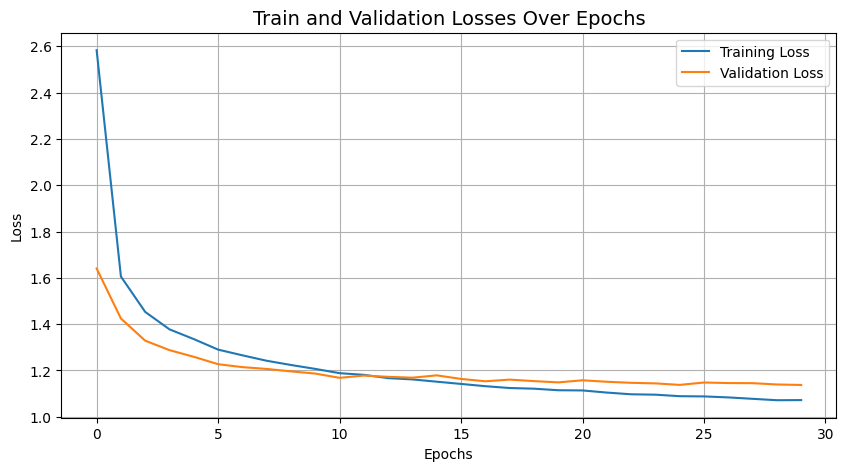

In [ ]:

# Plotting the training and validation loss
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
test_loss = 0.0
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
model_ft.eval()

for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad(): # turn off autograd for faster testing
        output = model_ft(data)
        loss = criterion(output, target)
    test_loss = loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    if len(target) == 32:
        for i in range(32):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

test_loss = test_loss / test_data_len
print('Test Loss: {:.4f}'.format(test_loss))
for i in range(len(classes)):
    if class_total[i] > 0:
        print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Test accuracy of %5s: NA" % (classes[i]))
print("Test Accuracy of %2d%% (%2d/%2d)" % (
            100*np.sum(class_correct)/np.sum(class_total), np.sum(class_correct), np.sum(class_total)
        ))

100%|██████████| 16/16 [01:25<00:00,  5.33s/it]

Test Loss: 0.0442
Test Accuracy of ADONIS: 80% ( 4/ 5)
Test Accuracy of AFRICAN GIANT SWALLOWTAIL: 100% ( 4/ 4)
Test Accuracy of AMERICAN SNOOT: 75% ( 3/ 4)
Test Accuracy of AN 88: 100% ( 5/ 5)
Test Accuracy of APPOLLO: 100% ( 4/ 4)
Test Accuracy of ARCIGERA FLOWER MOTH: 100% ( 5/ 5)
Test Accuracy of ATALA: 100% ( 5/ 5)
Test Accuracy of ATLAS MOTH: 100% ( 5/ 5)
Test Accuracy of BANDED ORANGE HELICONIAN: 100% ( 4/ 4)
Test Accuracy of BANDED PEACOCK: 100% ( 5/ 5)
Test Accuracy of BANDED TIGER MOTH: 80% ( 4/ 5)
Test Accuracy of BECKERS WHITE: 100% ( 5/ 5)
Test Accuracy of BIRD CHERRY ERMINE MOTH: 75% ( 3/ 4)
Test Accuracy of BLACK HAIRSTREAK: 100% ( 5/ 5)
Test Accuracy of BLUE MORPHO: 100% ( 5/ 5)
Test Accuracy of BLUE SPOTTED CROW: 80% ( 4/ 5)
Test Accuracy of BROOKES BIRDWING: 100% ( 5/ 5)
Test Accuracy of BROWN ARGUS: 100% ( 5/ 5)
Test Accuracy of BROWN SIPROETA: 100% ( 4/ 4)
Test Accuracy of CABBAGE WHITE: 100% ( 5/ 5)
Test Accuracy of CAIRNS BIRDWING: 100% ( 4/ 4)
Test Accuracy of CH